# Phylogenetic Distance Calculation from RhizCG 2013

Notes: Calculate phylogenetic distance using phylogeny created from rbcL and matK in phylogenerator 20160209_phylogeny.tre.  

# Init

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(foreach)
library(lsmeans)
library(Hmisc)
library(lme4)
library(lmerTest)
library(ggplot2)
library(plyr)
library(dplyr)
library(tidyr)
library(pbkrtest)
library(gridExtra)
library(reshape2)
library(picante)
library(ape)
library(phyloseq)
library(doParallel)


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: estimability

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattice

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: survival

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: For

In [3]:
%%R
# Initialize corMLPE 
source('/home/bryan/corMLPE/corMLPE.R')

## Set file locations

In [4]:
%%R
workDir = '/home/bryan/RhizCG/PhyDist/'
treeFile = '/home/bryan/RhizCG/PhyDist/20160209_phylogeny.tre'
NAMFile = '/home/bryan/RhizCG/PhyDist/NAM_founders_distanceMatrix_v2.txt'

### Read  tables table 

In [5]:
%%R 

NAMdist = read.table(NAMFile, header = TRUE)
#reorder so that NAMdist is in same order as log2fold change matrix
NAMdist = NAMdist[c(1:6, 8, 7, 9, 10), c(1:6, 8, 7, 9, 10)]

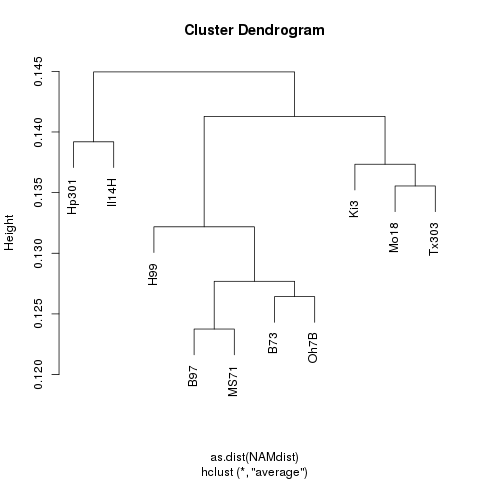

In [6]:
%%R
NAM_hc = hclust(as.dist(NAMdist), "average")
plot(NAM_hc)

In [7]:
%%R
#Read rarified phyloseq object
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_r')
physeq.Full = readRDS(F)

physeq.NAM = subset_samples(physeq.Full, Treatment == "Nneg" & Type == "Maize" & Plant != "75-062")
physeq.NAM

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 40 samples ]
sample_data() Sample Data:       [ 40 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


## NAM lines clustered by sampling date

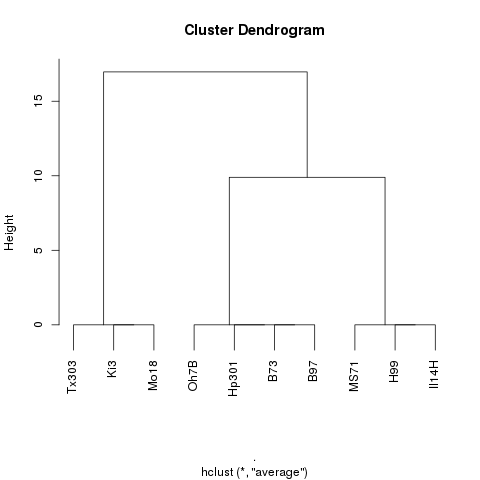

In [8]:
%%R
temp = sample_data(physeq.NAM) %>% 
    as(., "data.frame") %>% 
    group_by(Plant) %>% 
    summarize(DAY = mean(DAP)) #%>%
row.names(temp) = temp$Plant
dist(temp, method = "euclidean") %>%
    hclust("average") %>%
     plot

## Calculate w-Unifrac distances

In [9]:
%%R
registerDoParallel(cores=28)
phy.wunif.dist = distance(physeq.NAM, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


# Data wrangling 

## Create melted dataframes for plot by plot comparisons

In [10]:
%%R
gd.m = melt(as.matrix(NAMdist))

#set column names and create comparison column
colnames(gd.m) = c("PlantA", "PlantB", "gene_Dist")
gd.m$PlantComp = paste(gd.m$PlantA, gd.m$PlantB, sep = "-")
gd.m %>% head


  PlantA PlantB gene_Dist PlantComp
1    B73    B73 0.0000000   B73-B73
2    B97    B73 0.1285456   B97-B73
3    H99    B73 0.1306701   H99-B73
4  Hp301    B73 0.1357241 Hp301-B73
5  Il14H    B73 0.1412994 Il14H-B73
6    Ki3    B73 0.1413460   Ki3-B73


In [11]:
%%R
ud = as.matrix(phy.wunif.dist) 
# remove lower triangle to remove duplicate values
ud[ lower.tri( ud, diag = TRUE ) ]  <- NA
head(ud)
ud.m = melt(ud, na.rm= TRUE)
colnames(ud.m) = c("PlotA", "PlotB", "w_Unif_Dist")
head(ud.m) %>% print
dim(ud.m) %>% print

                PlotA             PlotB w_Unif_Dist
41  sample5-2.06_Nneg sample6-2.26_Nneg   0.1544908
81  sample5-2.06_Nneg sample6-3.18_Nneg   0.1652106
82  sample6-2.26_Nneg sample6-3.18_Nneg   0.1568328
121 sample5-2.06_Nneg sample5-3.13_Nneg   0.1293945
122 sample6-2.26_Nneg sample5-3.13_Nneg   0.1576011
123 sample6-3.18_Nneg sample5-3.13_Nneg   0.1265751
[1] 780   3


## Create functional distance variable

In [12]:
%%R
#add growing degree days
DAP = c(36, 53, 57, 61, 72, 79, 84, 88)
GDD = c(795.1, 1089.4, 1136.8, 1199.5, 1394.3, 1512.4, 1573.8, 1625.6)
M_GDD = cbind(DAP, GDD) %>% as.data.frame
M_GDD

Plant = c("ERATE", "HELAN", "B73", "FAGES", "AMAPO", "SORSUD", "SORBI", 
          "ELCOR", "ECHCG", "ABUTH", "SETFA", "GLYMA", "MS71", "Mo18", "Il14H", "Tx303", "Oh7B",
         "B97", "Hp301", "75-062", "Ki3", "H99")
SeedSize_mg = c(.0035, 90, 333, 38, .49, 10.7, 32.39,
               3.2, 1.58, 9.6, 1.8, 174, .264, .224, 0.219, 0.279, 0.207,
               0.240, 0.0869, 0.222, 0.228, 0.231)
SS = cbind(Plant, SeedSize_mg) %>% as.data.frame
head(SS) %>% print
SS$SeedSize_mg = SS$SeedSize_mg %>% as.character %>% as.numeric
(SS)

   Plant SeedSize_mg
1  ERATE      0.0035
2  HELAN          90
3    B73         333
4  FAGES          38
5  AMAPO        0.49
6 SORSUD        10.7
    Plant SeedSize_mg
1   ERATE      0.0035
2   HELAN     90.0000
3     B73    333.0000
4   FAGES     38.0000
5   AMAPO      0.4900
6  SORSUD     10.7000
7   SORBI     32.3900
8   ELCOR      3.2000
9   ECHCG      1.5800
10  ABUTH      9.6000
11  SETFA      1.8000
12  GLYMA    174.0000
13   MS71      0.2640
14   Mo18      0.2240
15  Il14H      0.2190
16  Tx303      0.2790
17   Oh7B      0.2070
18    B97      0.2400
19  Hp301      0.0869
20 75-062      0.2220
21    Ki3      0.2280
22    H99      0.2310


 [1] "B73"   "B97"   "H99"   "Hp301" "Il14H" "Ki3"   "Mo18"  "MS71"  "Oh7B" 
[10] "Tx303"
Importance of components:
                          PC1    PC2    PC3     PC4
Standard deviation     1.4160 1.2049 0.7101 0.19689
Proportion of Variance 0.5013 0.3630 0.1261 0.00969
Cumulative Proportion  0.5013 0.8642 0.9903 1.00000
                      PC1         PC2        PC3         PC4
SeedSize_mg    0.37559025  0.54897881 -0.7444181 -0.05827502
M_Resid_logN   0.62885977 -0.35501908  0.1089487 -0.68310104
M_Resid_logCN -0.01315932  0.75565140  0.5751346 -0.31311015
M_Resid_logB   0.68065717  0.03968222  0.3212353  0.65722068


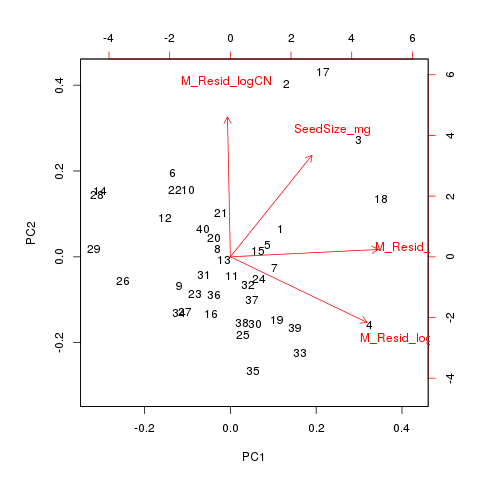

In [13]:
%%R
# PCA of maize
sd = as(sample_data(physeq.NAM), "data.frame")
sd$Plant %>% levels %>% print
sd = left_join(sd, SS, by = "Plant")
sd = left_join(sd, M_GDD, by = "DAP")

 fit = prcomp(~SeedSize_mg + M_Resid_logN + M_Resid_logCN + M_Resid_logB, data = sd, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

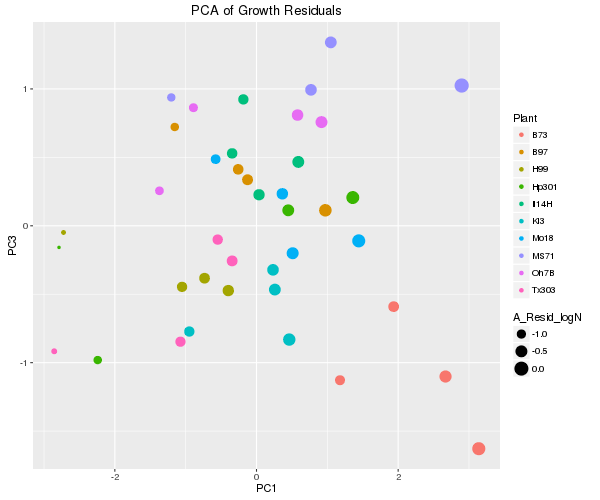

In [14]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
E_Fit = cbind(sd, S)
row.names(E_Fit) = E_Fit$X.sample
sample_data(physeq.NAM) = E_Fit


p = ggplot(E_Fit, aes(PC1, PC3, colour = Plant, 
                       size = A_Resid_logN), pch = 21)
p = p + geom_point()
#p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p

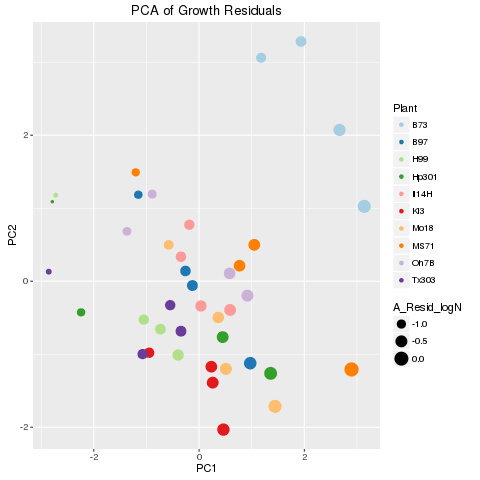

In [15]:
%%R
p = ggplot(E_Fit, aes(PC1, PC2, colour = Plant, 
                       size = A_Resid_logN), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p

In [16]:
%%R
#measure distances on PC1
sd = sample_data(physeq.NAM)
PC1dist = dist(sd[, "PC1"], method = "euclidian")
    #melt matrix
    PC1.m = melt(as.matrix(PC1dist))

    #set column names and create comparison column
     colnames(PC1.m) = c("PlotA", "PlotB", "PC1Dist")
    PC1.m$PlotComp = paste(PC1.m$PlotA, PC1.m$PlotB, sep = "-")
    PC1.m %>% head

#measure distances on PC2
PC2dist = dist(sd[,"PC2"], method = "euclidian")
    #melt matrix
    PC2.m = melt(as.matrix(PC2dist))

    #set column names and create comparison column
     colnames(PC2.m) = c("PlotA", "PlotB", "PC2Dist")
    PC2.m$PlotComp = paste(PC2.m$PlotA, PC2.m$PlotB, sep = "-")
    PC2.m %>% head

#measure distances on PC3
PC3dist = dist(sd[,"PC3"], method = "euclidian")
    #melt matrix
    PC3.m = melt(as.matrix(PC3dist))

    #set column names and create comparison column
     colnames(PC3.m) = c("PlotA", "PlotB", "PC3Dist")
    PC3.m$PlotComp = paste(PC3.m$PlotA, PC3.m$PlotB, sep = "-")
    PC3.m %>% head %>% print

#measure distances on residCN
CNdist = dist(sd[,"M_Resid_logCN"], method = "euclidian")
    #melt matrix
    CN.m = melt(as.matrix(CNdist))

    #set column names and create comparison column
     colnames(CN.m) = c("PlotA", "PlotB", "CNdist")
    CN.m$PlotComp = paste(CN.m$PlotA, CN.m$PlotB, sep = "-")
    CN.m %>% head %>% print

#measure distances on residBiomass
Bdist = dist(sd[,"M_Resid_logB"], method = "euclidian")
    #melt matrix
    B.m = melt(as.matrix(Bdist))

    #set column names and create comparison column
     colnames(B.m) = c("PlotA", "PlotB", "Bdist")
    B.m$PlotComp = paste(B.m$PlotA, B.m$PlotB, sep = "-")
    B.m %>% head %>% print

Fundist = dist(sd[,c("PC1", "PC2", "PC3")], method = "euclidian")
    Fun.m = melt(as.matrix(Fundist))

    #set column names and create comparison column
     colnames(Fun.m) = c("PlotA", "PlotB", "FunDist")
    Fun.m$PlotComp = paste(Fun.m$PlotA, PC3.m$PlotB, sep = "-")
    Fun.m %>% head %>% print
PCA.m = left_join(PC1.m, PC2.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, PC3.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, Fun.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, CN.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, B.m[,c(3,4)], by = "PlotComp")
head(PCA.m)

              PlotA             PlotB   PC3Dist
1 sample5-2.06_Nneg sample5-2.06_Nneg 0.0000000
2 sample6-2.26_Nneg sample5-2.06_Nneg 2.4689610
3 sample6-3.18_Nneg sample5-2.06_Nneg 2.4418318
4 sample5-3.13_Nneg sample5-2.06_Nneg 0.3154552
5 sample5-1.17_Nneg sample5-2.06_Nneg 0.3467816
6 sample5-4.08_Nneg sample5-2.06_Nneg 0.4024368
                             PlotComp
1 sample5-2.06_Nneg-sample5-2.06_Nneg
2 sample6-2.26_Nneg-sample5-2.06_Nneg
3 sample6-3.18_Nneg-sample5-2.06_Nneg
4 sample5-3.13_Nneg-sample5-2.06_Nneg
5 sample5-1.17_Nneg-sample5-2.06_Nneg
6 sample5-4.08_Nneg-sample5-2.06_Nneg
              PlotA             PlotB     CNdist
1 sample5-2.06_Nneg sample5-2.06_Nneg 0.00000000
2 sample6-2.26_Nneg sample5-2.06_Nneg 0.10793626
3 sample6-3.18_Nneg sample5-2.06_Nneg 0.05028337
4 sample5-3.13_Nneg sample5-2.06_Nneg 0.31288468
5 sample5-1.17_Nneg sample5-2.06_Nneg 0.08417796
6 sample5-4.08_Nneg sample5-2.06_Nneg 0.11968321
                             PlotComp
1 sample5-2.06_Nn

## Join distance tables

In [17]:
%%R
#Join with plant names
ud.m = left_join(ud.m, sd[, c(1,9)], by = c("PlotA" = "X.sample"))
head(ud.m) %>% print
colnames(ud.m)[4] = "PlantA"

ud.m = left_join(ud.m, sd[, c(1,9)], by = c("PlotB" = "X.sample"))
head(ud.m) %>% print
colnames(ud.m)[5] = "PlantB"
ud.m$PlantComp = paste(ud.m$PlantA, ud.m$PlantB, sep = "-")

#Create plot comparison for joining with functional distance matrix
ud.m$PlotComp = paste(ud.m$PlotA, ud.m$PlotB, sep = "-")
head(ud.m) %>% print

              PlotA             PlotB w_Unif_Dist Plant
1 sample5-2.06_Nneg sample6-2.26_Nneg   0.1544908  MS71
2 sample5-2.06_Nneg sample6-3.18_Nneg   0.1652106  MS71
3 sample6-2.26_Nneg sample6-3.18_Nneg   0.1568328   B73
4 sample5-2.06_Nneg sample5-3.13_Nneg   0.1293945  MS71
5 sample6-2.26_Nneg sample5-3.13_Nneg   0.1576011   B73
6 sample6-3.18_Nneg sample5-3.13_Nneg   0.1265751   B73
              PlotA             PlotB w_Unif_Dist PlantA Plant
1 sample5-2.06_Nneg sample6-2.26_Nneg   0.1544908   MS71   B73
2 sample5-2.06_Nneg sample6-3.18_Nneg   0.1652106   MS71   B73
3 sample6-2.26_Nneg sample6-3.18_Nneg   0.1568328    B73   B73
4 sample5-2.06_Nneg sample5-3.13_Nneg   0.1293945   MS71  MS71
5 sample6-2.26_Nneg sample5-3.13_Nneg   0.1576011    B73  MS71
6 sample6-3.18_Nneg sample5-3.13_Nneg   0.1265751    B73  MS71
              PlotA             PlotB w_Unif_Dist PlantA PlantB PlantComp
1 sample5-2.06_Nneg sample6-2.26_Nneg   0.1544908   MS71    B73  MS71-B73
2 sample5-2.06_Nneg

## Join with plant phylogenetic distance and functional distance

In [18]:
%%R
Dist = left_join(ud.m, gd.m[,c(3,4)], by = "PlantComp")
tail(Dist) %>% print

#Join with 
# Join DAP information and library information
Dist = left_join(Dist, sd[,c(1,2,13)], by = c("PlotA" = "X.sample"))
colnames(Dist)[9:10] = c("LibraryA","DAY_A")
tail(Dist) %>% print

Dist = left_join(Dist, sd[,c(1,2,13)], by = c("PlotB" = "X.sample"))
colnames(Dist)[11:12] = c("LibraryB","DAY_B")
tail(Dist) %>% print

Dist = left_join(Dist, PCA.m[,3:9], by = "PlotComp")

# set DAY_A and DAY_B as factor
Dist$DAY_A = as.factor(Dist$DAY_A)
Dist$DAY_B = as.factor(Dist$DAY_B)
Dist$TimeDist = abs(as.numeric(as.character(Dist$DAY_A)) - as.numeric(as.character(Dist$DAY_B)))

#create factor for cross library comps and same day comps
Dist$LibraryComp = ifelse(Dist$LibraryA == Dist$LibraryB, 0, 1) %>% as.factor
Dist$SameDay = ifelse(Dist$DAY_A == Dist$DAY_B, 0, 1) %>% as.factor

head(Dist)

                PlotA             PlotB w_Unif_Dist PlantA PlantB  PlantComp
775 sample8-2.22_Nneg sample8-4.04_Nneg   0.2488823  Tx303   Mo18 Tx303-Mo18
776 sample8-3.29_Nneg sample8-4.04_Nneg   0.2682512    Ki3   Mo18   Ki3-Mo18
777 sample8-3.28_Nneg sample8-4.04_Nneg   0.2630809  Tx303   Mo18 Tx303-Mo18
778 sample6-4.13_Nneg sample8-4.04_Nneg   0.1807210  Hp301   Mo18 Hp301-Mo18
779 sample8-1.23_Nneg sample8-4.04_Nneg   0.1509644    Ki3   Mo18   Ki3-Mo18
780 sample6-2.14_Nneg sample8-4.04_Nneg   0.2944427  Hp301   Mo18 Hp301-Mo18
                               PlotComp gene_Dist
775 sample8-2.22_Nneg-sample8-4.04_Nneg 0.1355506
776 sample8-3.29_Nneg-sample8-4.04_Nneg 0.1370860
777 sample8-3.28_Nneg-sample8-4.04_Nneg 0.1355506
778 sample6-4.13_Nneg-sample8-4.04_Nneg 0.1471428
779 sample8-1.23_Nneg-sample8-4.04_Nneg 0.1370860
780 sample6-2.14_Nneg-sample8-4.04_Nneg 0.1471428
                PlotA             PlotB w_Unif_Dist PlantA PlantB  PlantComp
775 sample8-2.22_Nneg sample8-4.04

# Build corMLPE models

## corMLPE models without random effects

In [19]:
%%R
str(Dist)

'data.frame':	780 obs. of  21 variables:
 $ PlotA      : chr  "sample5-2.06_Nneg" "sample5-2.06_Nneg" "sample6-2.26_Nneg" "sample5-2.06_Nneg" ...
 $ PlotB      : chr  "sample6-2.26_Nneg" "sample6-3.18_Nneg" "sample6-3.18_Nneg" "sample5-3.13_Nneg" ...
 $ w_Unif_Dist: num  0.154 0.165 0.157 0.129 0.158 ...
 $ PlantA     : chr  "MS71" "MS71" "B73" "MS71" ...
 $ PlantB     : chr  "B73" "B73" "B73" "MS71" ...
 $ PlantComp  : chr  "MS71-B73" "MS71-B73" "B73-B73" "MS71-MS71" ...
 $ PlotComp   : chr  "sample5-2.06_Nneg-sample6-2.26_Nneg" "sample5-2.06_Nneg-sample6-3.18_Nneg" "sample6-2.26_Nneg-sample6-3.18_Nneg" "sample5-2.06_Nneg-sample5-3.13_Nneg" ...
 $ gene_Dist  : num  0.126 0.126 0 0 0.126 ...
 $ LibraryA   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ DAY_A      : Factor w/ 3 levels "72","79","88": 1 1 2 1 2 2 1 2 2 1 ...
 $ LibraryB   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ DAY_B      : Factor w/ 3 levels "72","79","88": 2 2 2 1 1 1 1 1 1 1 ...
 $ PC1Dist    : num  0.13 1.62 1.49 1.85 1.72 ...
 $ PC2Dis

In [20]:
%%R
Data = filter(Dist, gene_Dist != 0) 

In [32]:
%%R
Data = Dist
#Base models
fit1 =  gls(w_Unif_Dist ~ gene_Dist, correlation = corMLPE(form= ~ PlotA + PlotB), data = Data)
Z <- corZ(fit2) #extract correlation structure from previous fit

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [21]:
%%R
#Base models
fit1 =  gls(w_Unif_Dist ~ 1, correlation = corMLPE(form= ~ PlotA + PlotB), data = Data)
Z <- corZ(fit1) #extract correlation structure from previous fit

In [22]:
%%R
summary(fit1)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ 1 
  Data: Data 
        AIC       BIC   logLik
  -2775.158 -2761.424 1390.579

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3198367 

Coefficients:
                Value   Std.Error  t-value p-value
(Intercept) 0.2076891 0.009516128 21.82496       0

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.6986396 -0.7477845 -0.1698686  0.5730852  3.2261110 

Residual standard error: 0.05279888 
Degrees of freedom: 720 total; 719 residual


In [23]:
%%R
#Controlling for time and batch effects, using same correlation structure
fit2 =  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp, 
             correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Data)
summary(fit2)


Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp 
  Data: Data 
        AIC       BIC   logLik
  -2737.856 -2710.414 1374.928

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3212053 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.20564984 0.009806707 20.970326  0.0000
TimeDist     -0.00052820 0.000566258 -0.932792  0.3512
SameDay1      0.00569633 0.005475127  1.040401  0.2985
LibraryComp1  0.00338605 0.003243685  1.043889  0.2969

 Correlation: 
             (Intr) TimDst SamDy1
TimeDist      0.016              
SameDay1     -0.101 -0.848       
LibraryComp1 -0.066 -0.566  0.326

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.7174237 -0.7592236 -0.1819536  0.5971622  3.2387181 

Residual standard error: 0.05302813 
Degrees of freedom: 720 total; 716 residual


In [24]:
%%R
#Hypothesis testing functional distance
fit3 =  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Data)
summary(fit3)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + PC1Dist + PC2Dist +      PC3Dist 
  Data: Data 
        AIC       BIC   logLik
  -2701.572 -2660.447 1359.786

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
     Rho 
0.323572 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.20347630 0.010699867 19.016713  0.0000
TimeDist     -0.00043814 0.000571579 -0.766549  0.4436
SameDay1      0.00486781 0.005538813  0.878854  0.3798
LibraryComp1  0.00286957 0.003326861  0.862547  0.3887
PC1Dist       0.00114840 0.001469054  0.781727  0.4346
PC2Dist       0.00148089 0.001769658  0.836823  0.4030
PC3Dist      -0.00175339 0.002679952 -0.654262  0.5132

 Correlation: 
             (Intr) TimDst SamDy1 LbrrC1 PC1Dst PC2Dst
TimeDist      0.006                                   
SameDay1     -0.096 -0.850                            
LibraryComp1  0.000 -0.565  0.331                     
P

In [31]:
%%R
#H2: phylogenetic dist
fit4 =  gls(w_Unif_Dist ~  gene_Dist, 
            correlation = corMLPE(form= ~ PlotA + PlotB), data = Data)
summary(fit4)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ gene_Dist 
  Data: Data 
        AIC       BIC   logLik
  -2772.892 -2754.586 1390.446

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3169767 

Coefficients:
                Value  Std.Error  t-value p-value
(Intercept) 0.1821804 0.04104625 4.438417  0.0000
gene_Dist   0.1828523 0.28639080 0.638471  0.5234

 Correlation: 
          (Intr)
gene_Dist -0.973

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.7148356 -0.7483326 -0.1672298  0.5883195  3.1881563 

Residual standard error: 0.05244076 
Degrees of freedom: 720 total; 718 residual


In [26]:
%%R
fit5 =  gls(w_Unif_Dist ~   poly(gene_Dist,2), 
             correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Data)
summary(fit5)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ poly(gene_Dist, 2) 
  Data: Data 
        AIC       BIC   logLik
  -2771.366 -2748.491 1390.683

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3138539 

Coefficients:
                         Value  Std.Error   t-value p-value
(Intercept)         0.20768913 0.00924522 22.464488  0.0000
poly(gene_Dist, 2)1 0.04066805 0.05623457  0.723186  0.4698
poly(gene_Dist, 2)2 0.10271714 0.03494037  2.939784  0.0034

 Correlation: 
                    (Intr) p(_D,2)1
poly(gene_Dist, 2)1 0.000          
poly(gene_Dist, 2)2 0.000  0.021   

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.6907727 -0.7566068 -0.1580642  0.6118045  3.2570820 

Residual standard error: 0.0517613 
Degrees of freedom: 720 total; 717 residual


In [27]:
%%R
#H3: combined phylogenetic distance and functional
fit6=  gls(w_Unif_Dist ~ TimeDist + gene_Dist + SameDay + LibraryComp + PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Data)
summary(fit6)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + gene_Dist + SameDay + LibraryComp +      PC1Dist + PC2Dist + PC3Dist 
  Data: Data 
        AIC       BIC   logLik
  -2699.677 -2653.996 1359.838

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3214679 

Coefficients:
                   Value Std.Error   t-value p-value
(Intercept)   0.18438519 0.0545893  3.377681  0.0008
TimeDist     -0.00052367 0.0006223 -0.841479  0.4004
gene_Dist     0.14125100 0.3956215  0.357036  0.7212
SameDay1      0.00527800 0.0056688  0.931058  0.3521
LibraryComp1  0.00254817 0.0034428  0.740136  0.4595
PC1Dist       0.00114027 0.0014701  0.775640  0.4382
PC2Dist       0.00141667 0.0017781  0.796733  0.4259
PC3Dist      -0.00175759 0.0026823 -0.655260  0.5125

 Correlation: 
             (Intr) TimDst gn_Dst SamDy1 LbrrC1 PC1Dst PC2Dst
TimeDist      0.387                                          
gene_Dist    -0.981 -0.394                    

In [28]:
%%R
anova(fit1, fit2, fit3, fit4, fit5, fit6)

     Model df       AIC       BIC   logLik   Test  L.Ratio p-value
fit1     1  3 -2775.158 -2761.424 1390.579                        
fit2     2  6 -2737.856 -2710.414 1374.928 1 vs 2 31.30153  <.0001
fit3     3  9 -2701.572 -2660.447 1359.786 2 vs 3 30.28405  <.0001
fit4     4  4 -2772.892 -2754.586 1390.446 3 vs 4 61.31943  <.0001
fit5     5  5 -2771.366 -2748.491 1390.683 4 vs 5  0.47457  0.4909
fit6     6 10 -2699.677 -2653.996 1359.838 5 vs 6 61.68959  <.0001


Notes: Genetic distance^2 is the best model on NAM lines

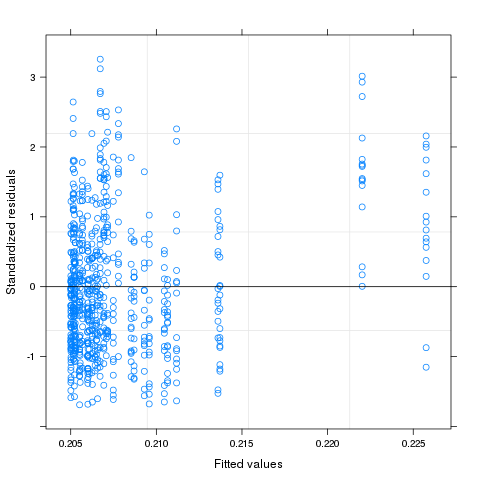

In [29]:
%%R
plot(fit5)

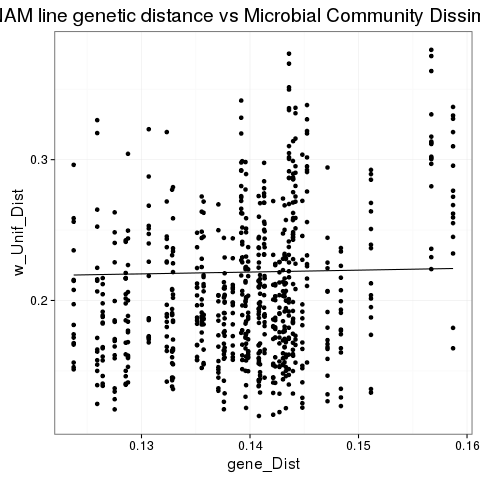

In [30]:
%%R
test <- function(x) {0.165*x ^ 2 + 0.0856*x + 0.205}


Data = filter(Dist, gene_Dist != 0)                
p = ggplot(Data, aes(y = w_Unif_Dist, x = gene_Dist)) 
p = p + geom_point() #aes(size = phy_Dist), shape = 1)
#p = p + stat_smooth(method = "lm", formula = y~.29x -.236x^2 + .204, se = FALSE)
p = p + theme_bw(base_size = 16)
p = p + ggtitle("NAM line genetic distance vs Microbial Community Dissimilarity ")
#p = p + stat_smooth(method = lm, se = FALSE)
p = p + stat_function(fun = test)
p

### Not used, but if date/combo is random effect:

In [50]:
%%R
Dist$DateCombo = ifelse(as.numeric(as.character(Dist$DAY_A)) < as.numeric(as.character(Dist$DAY_B)),
                                                                    paste(Dist$DAY_A, Dist$DAY_B, sep = "-"), 
                                                                   paste(Dist$DAY_B, Dist$DAY_A, sep = "-"))
Dist$DateCombo %>% unique


[1] "72-79" "79-79" "72-72" "72-88" "79-88" "88-88"


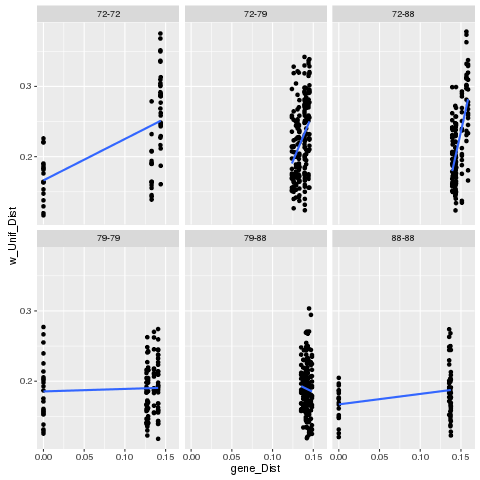

In [51]:
%%R

p = ggplot(Dist, aes(x = gene_Dist, y = w_Unif_Dist))
           p = p + geom_point()
        p = p + stat_smooth(method = "lm", se = FALSE)
           p = p + facet_wrap(~DateCombo)
           p

In [ ]:
# GLS model on early subset of plants

In [96]:
%%R
Dist$DAY_A %>% unique

[1] 72 61 36 79 53 57 88 84
Levels: 36 53 57 61 72 79 84 88


In [100]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, DAY_A %in% c( "53", "57", "61") & DAY_B %in% c( "53", "57", "61"))


dim(SubDist) %>% print
SubDist$PlantA %>% unique

[1] 3741   21
[1] 171  21
[1] SETFA AMAPO GLYMA ABUTH ECHCG
Levels: ABUTH AMAPO ECHCG GLYMA SETFA


In [102]:
%%R
#null model
fit1=  gls(w_Unif_Dist ~ 1, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)


In [103]:
%%R
fit2=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit2)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp 
  Data: SubDist 
        AIC       BIC   logLik
  -558.3834 -539.6754 285.1917

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
     Rho 
0.356982 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.22358741 0.018897504 11.831584  0.0000
TimeDist     -0.00119564 0.002296805 -0.520568  0.6034
SameDay1      0.02971877 0.012062939  2.463643  0.0148
LibraryComp1  0.00915773 0.005825444  1.572022  0.1178

 Correlation: 
             (Intr) TimDst SamDy1
TimeDist     -0.029              
SameDay1     -0.079 -0.869       
LibraryComp1 -0.147 -0.026  0.015

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.7777706 -0.7161677 -0.1849241  0.7073944  2.6578120 

Residual standard error: 0.0658017 
Degrees of freedom: 171 total; 167 residual


In [105]:
%%R
fit3=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit3)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -560.7067 -538.9227 287.3533

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3627573 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.21420874 0.019033895 11.254068  0.0000
TimeDist     0.00102593 0.002330110  0.440291  0.6603
SameDay1     0.00752057 0.013547030  0.555146  0.5795
LibraryComp1 0.00662430 0.005704172  1.161308  0.2472
phy_Dist     0.06718911 0.020710308  3.244235  0.0014

 Correlation: 
             (Intr) TimDst SamDy1 LbrrC1
TimeDist     -0.071                     
SameDay1      0.011 -0.865              
LibraryComp1 -0.120 -0.064  0.081       
phy_Dist     -0.152  0.292 -0.504 -0.136

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.6430402 -0.7702305 -0.2033792  0.6725299  2.7076473 

Residual stan

In [106]:
%%R
fit4=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit4)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,      2) 
  Data: SubDist 
        AIC       BIC   logLik
  -557.8762 -533.0287 286.9381

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3646452 

Coefficients:
                        Value  Std.Error   t-value p-value
(Intercept)        0.22925310 0.01923898 11.916071  0.0000
TimeDist           0.00134741 0.00233329  0.577473  0.5644
SameDay1           0.00813732 0.01350649  0.602475  0.5477
LibraryComp1       0.00998889 0.00618804  1.614226  0.1084
poly(phy_Dist, 2)1 0.13498897 0.04264280  3.165575  0.0018
poly(phy_Dist, 2)2 0.06828781 0.04957842  1.377370  0.1703

 Correlation: 
                   (Intr) TimDst SamDy1 LbrrC1 p(_D,2)1
TimeDist            0.003                              
SameDay1           -0.140 -0.857                       
LibraryComp1       -0.192 -0.020  0.088                
poly(phy_Dist, 2)1  0.148  0.

In [119]:
%%R
#H3: combined phylogenetic distance and functional
fit5=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit5)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + PC1Dist + PC2Dist +      PC3Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -529.7526 -501.8538 273.8763

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3603851 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.21209783 0.020575481 10.308281  0.0000
TimeDist      0.00043629 0.002520871  0.173071  0.8628
SameDay1      0.01742434 0.014620250  1.191795  0.2351
LibraryComp1  0.00878378 0.005891002  1.491051  0.1379
PC1Dist      -0.00034934 0.004702405 -0.074289  0.9409
PC2Dist       0.01099331 0.007809805  1.407630  0.1611
PC3Dist       0.00572024 0.004948599  1.155932  0.2494

 Correlation: 
             (Intr) TimDst SamDy1 LbrrC1 PC1Dst PC2Dst
TimeDist     -0.127                                   
SameDay1      0.066 -0.886                            
LibraryComp1 -0.133 -0.066  0.076                  

In [121]:
%%R
fit6=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist + PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit6)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist + PC1Dist +      PC2Dist + PC3Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -529.4817 -498.5442 274.7408

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.3606082 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.21368892 0.020203749 10.576696  0.0000
TimeDist      0.00144190 0.002499286  0.576924  0.5648
SameDay1      0.00415998 0.015134303  0.274871  0.7838
LibraryComp1  0.00635018 0.005845120  1.086407  0.2789
phy_Dist      0.06511136 0.023784881  2.737510  0.0069
PC1Dist      -0.00212631 0.004657169 -0.456567  0.6486
PC2Dist       0.00235977 0.008283370  0.284880  0.7761
PC3Dist       0.00219554 0.005021096  0.437263  0.6625

 Correlation: 
             (Intr) TimDst SamDy1 LbrrC1 phy_Ds PC1Dst PC2Dst
TimeDist     -0.121                                          
SameDay1      0.053 -0.877

# Subset of late season plants

In [142]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, PlantA %in% c("MS71",   "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI", "HELAN",    "Mo18") & PlantB %in% c("MS71", "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI",  "HELAN",  "Mo18"))
dim(SubDist) %>% print
SubDist$PlantA %>% unique

[1] 3741   21
[1] 378  21
[1] MS71   ERATE  ELCOR  SORSUD SORBI  HELAN  Mo18  
Levels: ELCOR ERATE HELAN Mo18 MS71 SORBI SORSUD


In [143]:
%%R
#null model
fit1=  gls(w_Unif_Dist ~ 1, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)

In [145]:
%%R
fit2=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit2)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp 
  Data: SubDist 
        AIC       BIC   logLik
  -1188.294 -1164.749 600.1472

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2638468 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.20726152 0.012748842 16.257281       0
TimeDist     -0.01329776 0.002075906 -6.405760       0
SameDay1      0.10693579 0.009681678 11.045171       0
LibraryComp1  0.15403404 0.021865247  7.044697       0

 Correlation: 
             (Intr) TimDst SamDy1
TimeDist     -0.029              
SameDay1     -0.099 -0.753       
LibraryComp1  0.022 -0.945  0.572

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.50747903 -0.71429885 -0.07986169  0.62268468  2.84825648 

Residual standard error: 0.06239944 
Degrees of freedom: 378 total; 374 residual


In [146]:
%%R
fit3=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit3)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -1226.818 -1199.367 620.4089

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2644966 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.19111878 0.012249524 15.602139       0
TimeDist     -0.01149179 0.001971390 -5.829283       0
SameDay1      0.09274108 0.009337957  9.931624       0
LibraryComp1  0.13963786 0.020688458  6.749554       0
phy_Dist      0.17609305 0.025188587  6.990986       0

 Correlation: 
             (Intr) TimDst SamDy1 LbrrC1
TimeDist     -0.053                     
SameDay1     -0.054 -0.757              
LibraryComp1  0.040 -0.945  0.577       
phy_Dist     -0.189  0.131 -0.217 -0.100

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.3838200 -0.6726156 -0.0429087  0.6623326  2.5876450 

Residua

In [147]:
%%R
fit4=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit4)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,      2) 
  Data: SubDist 
        AIC       BIC   logLik
  -1251.894 -1220.543 633.9469

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2426109 

Coefficients:
                        Value  Std.Error   t-value p-value
(Intercept)         0.2129254 0.01078911 19.735226       0
TimeDist           -0.0119258 0.00190638 -6.255750       0
SameDay1            0.0917000 0.00903601 10.148294       0
LibraryComp1        0.1430795 0.01997977  7.161221       0
poly(phy_Dist, 2)1  0.4111046 0.07029596  5.848196       0
poly(phy_Dist, 2)2 -0.2610320 0.04708820 -5.543470       0

 Correlation: 
                   (Intr) TimDst SamDy1 LbrrC1 p(_D,2)1
TimeDist           -0.027                              
SameDay1           -0.115 -0.756                       
LibraryComp1        0.020 -0.946  0.577                
poly(phy_Dist, 2)1  0.034  0.

In [148]:
%%R
#H3: combined phylogenetic distance and functional
fit5=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit5)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + PC1Dist + PC2Dist +      PC3Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -1254.068 -1218.822 636.0341

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2820758 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.17680501 0.012874880 13.732556  0.0000
TimeDist     -0.01268428 0.001937909 -6.545345  0.0000
SameDay1      0.08097260 0.009553704  8.475519  0.0000
LibraryComp1  0.16666353 0.020985365  7.941893  0.0000
PC1Dist       0.00109591 0.002192453  0.499855  0.6175
PC2Dist       0.02347960 0.002183360 10.753887  0.0000
PC3Dist       0.00041159 0.004666380  0.088203  0.9298

 Correlation: 
             (Intr) TimDst SamDy1 LbrrC1 PC1Dst PC2Dst
TimeDist     -0.119                                   
SameDay1      0.078 -0.768                            
LibraryComp1  0.126 -0.942  0.600                  

In [149]:
%%R
fit6=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,2) + PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit6)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,      2) + PC1Dist + PC2Dist + PC3Dist 
  Data: SubDist 
        AIC       BIC   logLik
  -1284.515 -1241.496 653.2576

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2711729 

Coefficients:
                         Value  Std.Error   t-value p-value
(Intercept)         0.18944455 0.01196993 15.826705  0.0000
TimeDist           -0.01213027 0.00185185 -6.550366  0.0000
SameDay1            0.07693807 0.00914662  8.411638  0.0000
LibraryComp1        0.16103412 0.01998579  8.057431  0.0000
poly(phy_Dist, 2)1  0.29934182 0.06649455  4.501750  0.0000
poly(phy_Dist, 2)2 -0.18059368 0.04403659 -4.100992  0.0001
PC1Dist             0.00000916 0.00208722  0.004390  0.9965
PC2Dist             0.01876434 0.00218932  8.570869  0.0000
PC3Dist            -0.00205743 0.00444239 -0.463136  0.6435

 Correlation: 
                   (Intr) TimDst Sam

In [150]:
%%R
anova(fit1, fit2, fit3, fit4, fit5, fit6)

     Model df       AIC       BIC   logLik   Test   L.Ratio p-value
fit1     1  3 -1015.341 -1003.544 510.6706                         
fit2     2  6 -1188.294 -1164.749 600.1472 1 vs 2 178.95325  <.0001
fit3     3  7 -1226.818 -1199.367 620.4089 2 vs 3  40.52338  <.0001
fit4     4  8 -1251.894 -1220.543 633.9469 3 vs 4  27.07596  <.0001
fit5     5  9 -1254.068 -1218.822 636.0341 4 vs 5   4.17436   0.041
fit6     6 11 -1284.515 -1241.496 653.2576 5 vs 6  34.44699  <.0001


# Maize distance analysis

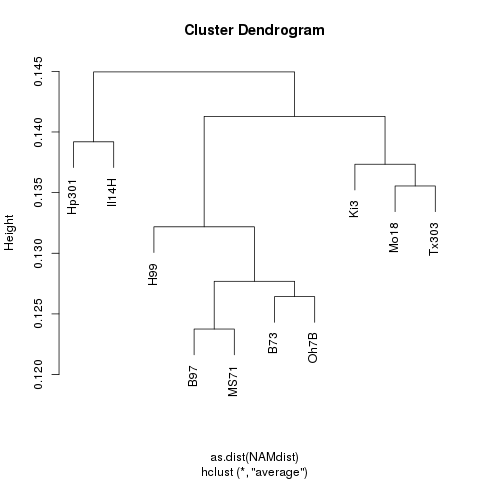

In [151]:
%%R
NAM_hc = hclust(as.dist(NAMdist), "average")
plot(NAM_hc)

In [ ]:
%%R
physeq.Maize = subset_samples(physeq.Full, Type == "Maize" & Plant != "75-062")
as(sample_data(physeq.Maize), "data.frame") %>%

group_by(Plant) %>%
   summarise(DATE = first(DAP)) %>% 
    arrange(DATE) %>%
   print()

In [153]:
%%R
Dist %>% dim %>% print
#Use melt to join genetic distance matrix with unifrac distance
#head(ud.m) ##Use formated unifrac distance from above
#melt 
NAM.m = melt(as.matrix(NAMdist))

#set column names and create comparison column
colnames(NAM.m) = c("PlantA", "PlantB", "gene_Dist")

NAM.m$PlantComp = paste(NAM.m$PlantA, NAM.m$PlantB, sep = "-")
NAM.m %>% head

#Join with unifrac DistanceMatrix
NAMDist = left_join(Dist, NAM.m[,c(3,4)], by = "PlantComp") %>% filter(!is.na(gene_Dist))
NAMDist %>% dim %>% print
NAMDist %>% head

[1] 3741   21
[1] 780  22
              PlotA             PlotB w_Unif_Dist PlantA PlantB PlantComp
1 sample5-2.06_Nneg sample6-2.26_Nneg   0.1544908   MS71    B73  MS71-B73
2 sample5-2.06_Nneg sample6-3.18_Nneg   0.1652106   MS71    B73  MS71-B73
3 sample6-2.26_Nneg sample6-3.18_Nneg   0.1568328    B73    B73   B73-B73
4 sample5-2.06_Nneg sample5-3.13_Nneg   0.1293945   MS71   MS71 MS71-MS71
5 sample6-2.26_Nneg sample5-3.13_Nneg   0.1576011    B73   MS71  B73-MS71
6 sample6-3.18_Nneg sample5-3.13_Nneg   0.1265751    B73   MS71  B73-MS71
                             PlotComp phy_Dist LibraryA DAY_A LibraryB DAY_B
1 sample5-2.06_Nneg-sample6-2.26_Nneg    2e-04        1    72        1    79
2 sample5-2.06_Nneg-sample6-3.18_Nneg    2e-04        1    72        1    79
3 sample6-2.26_Nneg-sample6-3.18_Nneg    0e+00        1    79        1    79
4 sample5-2.06_Nneg-sample5-3.13_Nneg    0e+00        1    72        1    72
5 sample6-2.26_Nneg-sample5-3.13_Nneg    2e-04        1    79        1 

In [157]:
%%R
fit1=  gls(w_Unif_Dist ~ 1, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = NAMDist)
summary(fit1)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ 1 
  Data: NAMDist 
        AIC      BIC   logLik
  -2867.424 -2853.45 1436.712

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2682316 

Coefficients:
                Value   Std.Error  t-value p-value
(Intercept) 0.2052307 0.008566936 23.95613       0

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.7135817 -0.7558845 -0.1763719  0.5780333  3.3397603 

Residual standard error: 0.05173829 
Degrees of freedom: 780 total; 779 residual


In [160]:
%%R
fit2=  gls(w_Unif_Dist ~  SameDay + LibraryComp, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = NAMDist)
summary(fit2)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + LibraryComp 
  Data: NAMDist 
       AIC       BIC   logLik
  -2858.33 -2835.053 1434.165

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2701848 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.19789457 0.008770511 22.563630  0.0000
SameDay1     0.00928251 0.002993688  3.100692  0.0020
LibraryComp1 0.00213801 0.002885287  0.741003  0.4589

 Correlation: 
             (Intr) SamDy1
SameDay1     -0.162       
LibraryComp1 -0.063 -0.429

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.7550017 -0.7404351 -0.1834046  0.5558079  3.4440568 

Residual standard error: 0.05151474 
Degrees of freedom: 780 total; 777 residual


In [161]:
%%R
fit3=  gls(w_Unif_Dist ~ SameDay + LibraryComp + gene_Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = NAMDist)
summary(fit3)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + LibraryComp + gene_Dist 
  Data: NAMDist 
        AIC       BIC   logLik
  -2889.658 -2861.733 1450.829

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2728994 

Coefficients:
                   Value  Std.Error   t-value p-value
(Intercept)   0.17437941 0.00943202 18.488021  0.0000
SameDay1      0.00215335 0.00313664  0.686514  0.4926
LibraryComp1 -0.00140721 0.00287286 -0.489828  0.6244
gene_Dist     0.23363819 0.03742784  6.242363  0.0000

 Correlation: 
             (Intr) SamDy1 LbrrC1
SameDay1      0.009              
LibraryComp1  0.023 -0.319       
gene_Dist    -0.399 -0.364 -0.198

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.7682577 -0.7570730 -0.1597296  0.5890162  3.3097276 

Residual standard error: 0.05057387 
Degrees of freedom: 780 total; 776 residual


In [163]:
%%R
fit4=  gls(w_Unif_Dist ~  SameDay + LibraryComp + poly(gene_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = NAMDist)
summary(fit4)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + LibraryComp + poly(gene_Dist, 2) 
  Data: NAMDist 
        AIC       BIC   logLik
  -2896.295 -2863.725 1455.147

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2594639 

Coefficients:
                          Value  Std.Error   t-value p-value
(Intercept)          0.20822378 0.00831887 25.030305  0.0000
SameDay1             0.00002431 0.00317938  0.007645  0.9939
LibraryComp1        -0.00611317 0.00314554 -1.943443  0.0523
poly(gene_Dist, 2)1  0.30500667 0.04258550  7.162218  0.0000
poly(gene_Dist, 2)2  0.21032885 0.05917875  3.554128  0.0004

 Correlation: 
                    (Intr) SamDy1 LbrrC1 p(_D,2)1
SameDay1            -0.220                       
LibraryComp1        -0.133 -0.206                
poly(gene_Dist, 2)1  0.165 -0.403 -0.326         
poly(gene_Dist, 2)2  0.127 -0.190 -0.417  0.381  

Standardized residuals:
       Min         Q1        Med        

In [168]:
%%R
fit5=  gls(w_Unif_Dist ~ SameDay + LibraryComp + PC1Dist + PC2Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = NAMDist)
summary(fit5)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + LibraryComp + PC1Dist + PC2Dist 
  Data: NAMDist 
        AIC       BIC   logLik
  -2840.303 -2807.733 1427.151

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2782163 

Coefficients:
                   Value   Std.Error   t-value p-value
(Intercept)   0.19011587 0.009486667 20.040323  0.0000
SameDay1      0.00910689 0.002983834  3.052076  0.0024
LibraryComp1 -0.00015745 0.003191976 -0.049328  0.9607
PC1Dist       0.00431410 0.002236009  1.929374  0.0540
PC2Dist       0.00386152 0.002242537  1.721942  0.0855

 Correlation: 
             (Intr) SamDy1 LbrrC1 PC1Dst
SameDay1     -0.144                     
LibraryComp1  0.024 -0.364              
PC1Dist      -0.256  0.015  0.019       
PC2Dist      -0.183 -0.048 -0.436 -0.015

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.7478939 -0.7396423 -0.1599548  0.5489181  3.4670639 

Residual 

In [167]:
%%R
fit6=  gls(w_Unif_Dist ~ SameDay + LibraryComp + poly(gene_Dist,2) + PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = NAMDist)
summary(fit6)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ SameDay + LibraryComp + poly(gene_Dist, 2) + PC1Dist +      PC2Dist + PC3Dist 
  Data: NAMDist 
        AIC      BIC  logLik
  -2866.459 -2819.97 1443.23

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.2644892 

Coefficients:
                          Value  Std.Error   t-value p-value
(Intercept)          0.20444513 0.00916989 22.295262  0.0000
SameDay1             0.00002899 0.00317128  0.009140  0.9927
LibraryComp1        -0.00783234 0.00340184 -2.302382  0.0216
poly(gene_Dist, 2)1  0.30923669 0.04350716  7.107719  0.0000
poly(gene_Dist, 2)2  0.20951679 0.05950615  3.520927  0.0005
PC1Dist              0.00429081 0.00219529  1.954552  0.0510
PC2Dist              0.00286555 0.00219651  1.304591  0.1924
PC3Dist             -0.00469335 0.00342768 -1.369248  0.1713

 Correlation: 
                    (Intr) SamDy1 LbrrC1 p(_D,2)1 p(_D,2)2 PC1Dst PC2Dst
SameDay1            -0.208  

# Time vs MCC mantel test

In [ ]:
%%R
sample_data(physeq.Nneg)$DAP

In [ ]:
%%R
sd = sample_data(physeq.Nneg)

# Calculate w-unifrac distances
registerDoParallel(cores=28)
date.wunif.dist = distance(physeq.Nneg, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
Fun_dist = dist(sd[,c("DAP")], method = "euclidian")


M1 = mantel(date.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1

In [ ]:
%%R
mcc.correlog <- mantel.correlog(date.wunif.dist, Fun_dist, nperm=99)
summary(mcc.correlog) %>% print
mcc.correlog  %>% print
plot(mcc.correlog) 

# Ignore below this point

# Compare plant phylogenetic distance to l2f

In [ ]:
%%R
# log2foldFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/bare-plant.csv'
# l2f = read.csv(log2foldFile, header = TRUE)
# colnames(l2f)

### Spread by plant to make matrix of log2fold change in each OTU by plant combo

In [ ]:
%%R
# df = l2f[,c(1,11,13)]
# l2f_m = spread(df, Plant, log2FoldChange, fill = 0, drop = TRUE)
# rownames(l2f_m) = l2f_m$OTU
# l2f_m = l2f_m[,-1]
# l2f_m %>% head

In [ ]:
%%R
# dim(l2f_m)

### recode all negative log2fold changes with 0

In [ ]:
%%R
# l2f_me = l2f_m
# l2f_me[l2f_me < 0] = 0 
# head(l2f_me)

## Calculate pairwise weighted Unifrac distances between samples

need to figure out how to run unifrac measure outside of phyloseq

In [ ]:
%%R
# physeq.Full

In [ ]:
%%R
# #provide fast tree for unifrac calculation
# #treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'
# #Tree = read.tree(treeFile)
# Tree = phy_tree(physeq.Full)
# str(Tree)


In [ ]:
%%R
# l2f_wunif = picante::unifrac(as.matrix(t(l2f_me)), Tree)

In [ ]:
%%R
# l2f_bray = vegdist(as.matrix(t(l2f_me)), method = "bray")

In [ ]:
%%R
# hc_unif = hclust(l2f_wunif, "average")
# plot(hc_unif) %>% print

# hc_bray = hclust(l2f_bray, "average")
# plot(hc_bray, main = "Cluster Dendrogram, \n Bray-Curtis Distance")

# Mantel test of phylogenetic distance and l2f unifrac distance

### Maize

In [ ]:
%%R
# NAMdist %>% print

# #subset column and rows of log2fold change so that only NAM lines are included
# NLU = as.matrix(l2f_wunif)
# NLU = NLU[c(4,5,11,13:18,22),c(4,5,11,13:18,22)]
# NLU

# NLB = as.matrix(l2f_bray)
# NLB = NLB[c(4,5,11,13:18,22),c(4,5,11,13:18,22)]
# NLB

In [ ]:
%%R
# M1 = mantel(as.dist(NAMdist), as.dist(NLU), method="pearson", permutations=999)
# print(M1)

In [ ]:
%%R
# M1 = mantel(as.dist(NAMdist), as.dist(NLB), method="pearson", permutations=999)
# print(M1)

### Species

In [ ]:
%%R

# #Organize log2fold change distance matrix so that only plants with cholorplast distances are included 
# #and column and row order is congruent with phylogenetic distance matrix
# l2f_wunif.t = as.matrix(l2f_wunif) %>% as.data.frame()
#     temp1 = l2f_wunif.t[c("FAGES", "AMAPO", "HELAN", "ABUTH", "GLYMA", "SORBI", "B73", "ECHCG",
#                     "SETFA", "ERATE", "ELCOR"), c("FAGES", "AMAPO", "HELAN", "ABUTH", "GLYMA", "SORBI", "B73", "ECHCG",
#                     "SETFA", "ERATE", "ELCOR")]

#     SLU = as.matrix(temp1)

#     SLU = as.dist(SLU)
#     SLU %>% print

# #Remove ginkgo so that matrices are congruent
# p.temp = as.matrix(phydist) %>% as.data.frame()
#     temp2 = p.temp[-12, -12] #remove ginkgo

#     temp2 = as.matrix(temp2)
#     phydist = as.dist(temp2)

#     phydist %>% print

# l2f_bray.t = as.matrix(l2f_bray) %>% as.data.frame()
#     temp2 = l2f_bray.t[c("FAGES", "AMAPO", "HELAN", "ABUTH", "GLYMA", "SORBI", "B73", "ECHCG",
#                     "SETFA", "ERATE", "ELCOR"), c("FAGES", "AMAPO", "HELAN", "ABUTH", "GLYMA", "SORBI", "B73", "ECHCG",
#                     "SETFA", "ERATE", "ELCOR")]

#     SLB = as.matrix(temp2)
#     SLB = as.dist(SLB)
#     SLB %>% print


In [ ]:
%%R
# m1 = mantel(phydist, SLU, method="pearson", permutations=999)
# print(m1)

In [ ]:
%%R
# m1 = mantel(phydist, SLB, method="pearson", permutations=999)
# print(m1)